🤖 Phase 5.8: Zeta-Agent Resonance Mode. Threshold 0.5.
Episode 10	Score: 16.00	Teleports: 3
Episode 20	Score: 49.00	Teleports: 4
Episode 30	Score: 49.00	Teleports: 4
Episode 40	Score: 38.00	Teleports: 4
Episode 50	Score: 91.00	Teleports: 4
Episode 60	Score: 83.00	Teleports: 4
Episode 70	Score: 299.00	Teleports: 4
Episode 80	Score: 500.00	Teleports: 4
Episode 90	Score: 359.00	Teleports: 4
Episode 100	Score: 204.00	Teleports: 4


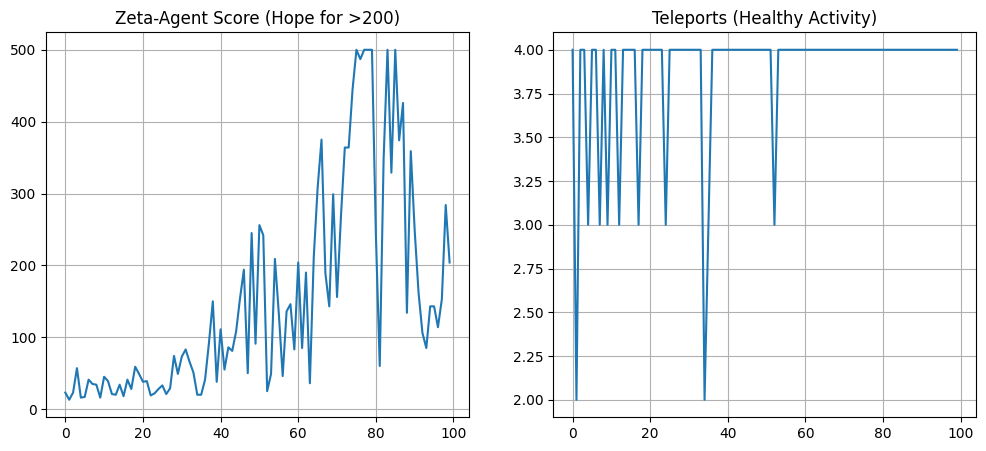

In [ ]:
# --- Phase 5.8: Zeta-RL Resonance (The Sweet Spot) ---
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Brain
class ZetaPolicy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(ZetaPolicy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.softmax(x, dim=1)

# Optimizer: Resonance Mode
class ZetaAdamW_RL_Resonance(optim.AdamW):
    def __init__(self, params, lr=0.005, zeta_thresh=0.5): # 🚨 阈值 0.5 (ResNet同款)，LR 降至 0.005
        super().__init__(params, lr=lr)
        self.zeta_thresh = zeta_thresh
        self.teleport_count = 0

    @torch.no_grad()
    def step(self, closure=None):
        loss = super().step(closure)
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue
                grad_norm = torch.norm(p.grad)

                # 如果梯度 > 0.5 (稍微有点混乱)，就启动瞬移
                if grad_norm > self.zeta_thresh:
                    unit_grad = p.grad / (grad_norm + 1e-9)
                    # 瞬移
                    p.data.sub_((1.0/12.0) * unit_grad)
                    self.teleport_count += 1
        return loss

# 训练配置
env = gym.make('CartPole-v1')
policy = ZetaPolicy()
# 使用更细腻的 LR + 0.5 阈值
optimizer = ZetaAdamW_RL_Resonance(policy.parameters(), lr=0.005, zeta_thresh=0.5)
gamma = 0.99

print("🤖 Phase 5.8: Zeta-Agent Resonance Mode. Threshold 0.5.")

scores = []
teleports = []

# 跑 100 回合，给它足够的时间顿悟
for i_episode in range(100):
    state, _ = env.reset()
    log_probs = []
    rewards = []
    optimizer.teleport_count = 0

    for t in range(500):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = policy(state)
        action = torch.multinomial(probs, 1).item()
        log_prob = torch.log(probs[0, action])
        log_probs.append(log_prob)
        state, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)
        if terminated or truncated:
            break

    scores.append(sum(rewards))

    # Update
    dis_rewards = []
    R = 0
    for r in rewards[::-1]:
        R = r + gamma * R
        dis_rewards.insert(0, R)
    dis_rewards = torch.tensor(dis_rewards)
    if len(dis_rewards) > 1:
        dis_rewards = (dis_rewards - dis_rewards.mean()) / (dis_rewards.std() + 1e-9)

    policy_loss = []
    for log_prob, R in zip(log_probs, dis_rewards):
        policy_loss.append(-log_prob * R)

    if len(policy_loss) > 0:
        optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        optimizer.step()

    teleports.append(optimizer.teleport_count)

    if (i_episode + 1) % 10 == 0:
        print(f"Episode {i_episode + 1}\tScore: {sum(rewards):.2f}\tTeleports: {optimizer.teleport_count}")

# 绘图
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.plot(scores); plt.title('Zeta-Agent Score (Hope for >200)'); plt.grid(True)
plt.subplot(1,2,2); plt.plot(teleports); plt.title('Teleports (Healthy Activity)'); plt.grid(True)
plt.show()